In [1]:
import numpy as np
import matplotlib.pyplot as plt


Total Regret after 1000 timesteps: 52.69999999999996 with assumed best arm 2


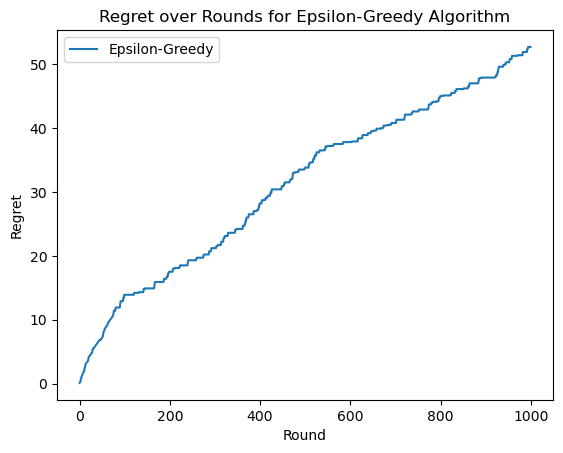

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Arm:
    def __init__(self, success_probability):
        self.success_probability = success_probability
    
    def pull(self):
        return np.random.binomial(1, self.success_probability)

class MultiBandit:
    def __init__(self, arm_probabilities=[0.5, 0.1, 0.6, 0.3]):
        self.arms = [Arm(prob) for prob in arm_probabilities]
        self.regret_total = 0
        self.max_probability = max(arm_probabilities)

    def num_arms(self):
        return len(self.arms)

    def pull(self, arm_index):
        reward = self.arms[arm_index].pull()
        self.regret_total += self.max_probability - self.arms[arm_index].success_probability
        return reward
    
    def regret(self):
        return self.regret_total

class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon_value):
        self.num_arms = num_arms
        self.horizon = horizon
        self.epsilon = epsilon_value
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        return np.argmax(self.arm_rewards / (self.arm_pulls + 1))

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_arms)
        else:
            return np.argmax(self.arm_rewards / (self.arm_pulls + 1))

    def run_algorithm(self, bandit):
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            self.arm_pulls[arm_to_pull] += 1
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1
            self.regrets[_] = bandit.regret()

    def plot(self):
        plt.plot(self.regrets, label='Epsilon-Greedy')
        plt.xlabel('Round')
        plt.ylabel('Regret')
        plt.legend()
        plt.title('Regret over Rounds for Epsilon-Greedy Algorithm')
        plt.show()


bandit = MultiBandit()


horizon_size = 1000


epsilon_value = 0.2
algorithm = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=horizon_size, epsilon_value=epsilon_value)


algorithm.run_algorithm(bandit)

print(f"Total Regret after {horizon_size} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")
algorithm.plot()


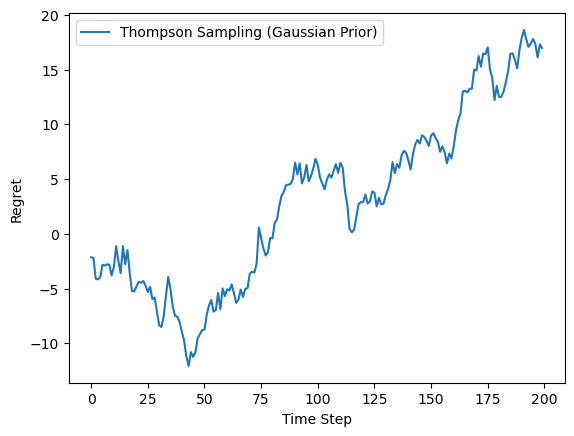

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class ThompsonSamplingGaussianPrior:
    def __init__(self, num_arms, mu_0=0, sigma_0=1):
        self.num_arms = num_arms
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.mu = np.ones(num_arms) * mu_0
        self.sigma = np.ones(num_arms) * sigma_0
        self.total_rewards = np.zeros(num_arms)

    def select_arm(self):
        sampled_theta = np.random.normal(self.mu, self.sigma)
        chosen_arm = np.argmax(sampled_theta)
        return chosen_arm

    def update(self, arm, reward):
        self.total_rewards[arm] += reward
        self.sigma[arm] = 1.0 / np.sqrt(1.0 / self.sigma_0**2 + sum(self.total_rewards))
        self.mu[arm] = self.sigma[arm]**2 * (self.mu_0 / self.sigma_0**2 + sum(self.total_rewards) / self.sigma[arm]**2)

    def run_algorithm(self, bandit, horizon):
        regrets = []
        for t in range(horizon):
            chosen_arm = self.select_arm()
            reward = bandit.pull_arm(chosen_arm)
            self.update(chosen_arm, reward)
            optimal_reward = max(bandit.true_means)
            regrets.append(optimal_reward - reward)
        return np.cumsum(regrets)

class MultiBandit:
    def __init__(self, true_means):
        self.true_means = true_means

    def pull_arm(self, arm):
        return np.random.normal(self.true_means[arm], 1.0)


bandit = MultiBandit(true_means=[1.0, 2.0, 3.0])
horizon = 200
thompson_algorithm = ThompsonSamplingGaussianPrior(num_arms=len(bandit.true_means))
regrets_thompson = thompson_algorithm.run_algorithm(bandit, horizon)

plt.plot(regrets_thompson, label='Thompson Sampling (Gaussian Prior)')
plt.xlabel('Time Step')
plt.ylabel('Regret')
plt.legend()
plt.show()


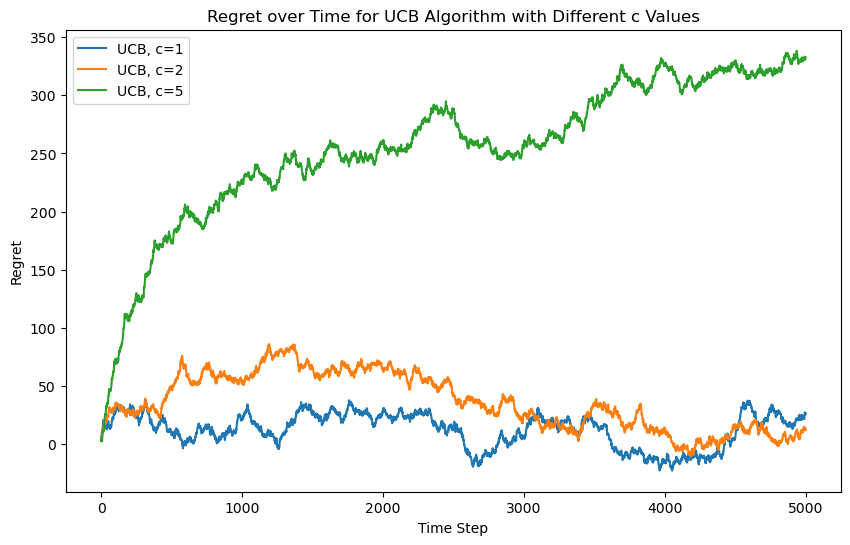

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class UCB:
    def __init__(self, k, c=1):
        self.k = k
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.t = 0
        self.c = c

    def select(self):
        U = self.Q + self.c * np.sqrt(np.log(self.t + 1) / (self.N + 1e-6))
        return np.argmax(U)

    def update(self, a, R):
        self.N[a] += 1
        self.Q[a] += (R - self.Q[a]) / self.N[a]
        self.t += 1

class MultiArmedBandit:
    def __init__(self, true_means):
        self.true_means = true_means

    def pull_arm(self, arm):
        return np.random.normal(self.true_means[arm], 1.0)

def run_experiment(k, T, c, bandit):
    ucb = UCB(k=k, c=c)

    regs = []

    for t in range(T):
        a = ucb.select()
        reward = bandit.pull_arm(a)
        ucb.update(a, reward)

        opt_reward = np.max(bandit.true_means)
        regret = opt_reward - reward
        regs.append(regret)

    cum_regs = np.cumsum(regs)
    return cum_regs

k = 4
T = 5000
c_vals = [1, 2, 5]
true_means = [1, 2, 3, 4]  

plt.figure(figsize=(10, 6))
bandit = MultiArmedBandit(true_means)

for c_val in c_vals:
    regs = run_experiment(k, T, c_val, bandit)
    plt.plot(regs, label=f'UCB, c={c_val}')

plt.xlabel('Time Step')
plt.ylabel('Regret')
plt.legend()
plt.title('Regret over Time for UCB Algorithm with Different c Values')
plt.show()
